In [1]:
#Imports
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Wrangle Data

## Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


## Parse Datetime

In [5]:
# begin cleaning up the timeline by removing the brackets and extraneous tail
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [6]:
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [7]:
#replace the first colon in the timestamp before year
# to accomadate for pandas datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
#reset index to time
df = df.set_index('timestamp')

In [8]:
df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


# Cleanup Text

In [9]:
# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


# Add Variable - Converting bytes to mb:

In [10]:
# 
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [11]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [12]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(dropna=False),'\n')

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
52.87.230.102         2
35.175.171.137        2
70.121.214.34         2
95.31.16.121          1
34.207.64.242         1
52.91.30.150          1
97.105.15.120         1
54.172.14.223         1
35.174.209.2          1
52.90.165.200         1
45.23.250.16          1
3.88.129.158          1
34.229.70.250         1
95.31.18.119          1
3.92.201.136          1
54.145.52.184         1
Name: ip, dtype: int64 

request_method
GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1            

# Detecting Anomalies in Discrete Variables

Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [13]:
ip_df = pd.DataFrame(df.ip.value_counts())
ip_df["proba"] = ip_df.ip / df.shape[0]
ip_df

,ip,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502
24.26.242.9,21,0.001502
52.87.230.102,2,0.000143
35.175.171.137,2,0.000143
70.121.214.34,2,0.000143
95.31.16.121,1,0.000072


In [14]:
# get the counts of ips in the dataset
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
# get the probability of that ip in the dataset
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
# merge/join these together
ip_df = ip_df.merge(ip_df2)


# alter the df to only see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,35.175.171.137,2,0.000143
8,70.121.214.34,2,0.000143
9,95.31.16.121,1,0.000072
10,34.207.64.242,1,0.000072
11,52.91.30.150,1,0.000072
12,97.105.15.120,1,0.000072
13,54.172.14.223,1,0.000072


In [15]:
# get the counts of request method in the dataset
rm_df = df.request_method.value_counts(dropna=False).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rm_count'})

In [16]:
# get the probability of that request methos in the dataset
rm_df2 = (df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rm_proba'})

In [17]:
# merge/join these together
rm_df = rm_df.merge(rm_df2)
# alter the rm df to only see those where rate < 1% 
rm_df[rm_df.rm_proba < 0.01]

,request_method,rm_count,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/store HTTP/1.1,3,0.000215
11,GET /api/v1/sales/HTTP/1.1,3,0.000215
12,GET /api/v1/sales/ HTTP/1.1,3,0.000215


In [18]:
rm_df.head()

,request_method,rm_count,rm_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [19]:
rm_df.shape

(22, 3)

22
                                  request_method  rm_count  rm_proba
12                   GET /api/v1/sales/ HTTP/1.1         3  0.000215
13               GET /api/v1/itemsitems HTTP/1.1         3  0.000215
14                     GET /api/v1items HTTP/1.1         2  0.000143
15                    GET /api/v1/items/HTTP/1.1         1  0.000072
16        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1  0.000072
17              GET /api/v1/helloclass! HTTP/1.1         1  0.000072
18                  GET /api/V1/HiZach! HTTP/1.1         1  0.000072
19                          GET /api/v1 HTTP/1.1         1  0.000072
20  GET /api/v1//api/v1/items/next_page HTTP/1.1         1  0.000072
21             GET /api/v1/items&page=0 HTTP/1.1         1  0.000072


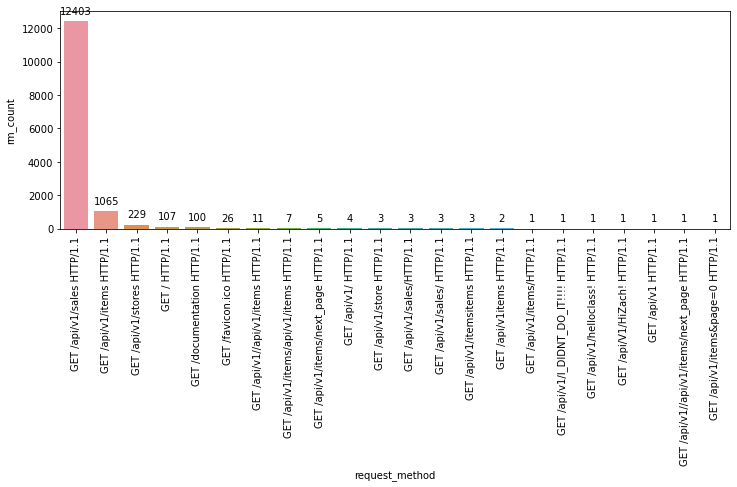

In [20]:
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data= rm_df, x = 'request_method', y = 'rm_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    
plt.xticks(rotation='vertical')
plt.show()

# <font color ="green"><u>Detecting anomalies by establishing a baseline and evaluate as new data arrives.</u></font>

  ## <font color ="cyan"> **Establish Baseline:**</font>

In [21]:
# creating a training set 
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']


In [22]:
train.size / df.size

0.9997138360280441

In [23]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

# <font color="blue">**Compute probabilities based on train sample:**</font>

In [24]:
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/ train.request_method.count()).reset_index().rename(columns ={
                        'index': 'request_method','request_method': 'rm_proba'})

# <font color="darkgreen"> **Merge probabilities with all data (train + new data):**</font>

   * Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [25]:
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.rm_proba.value_counts()

0.887577    12403
0.076213     1065
0.016388      229
0.007657      107
0.007156      100
0.001861       26
0.000787       11
0.000215        9
0.000501        7
0.000072        6
0.000358        5
0.000286        4
0.000000        4
0.000143        2
Name: rm_proba, dtype: int64

In [26]:
#value counts 
df[df['rm_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,0,python-requests/2.21.0,0.002441,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,2056327,0,python-requests/2.21.0,1.961066,0.0


# <font color="purple"><u>Conditional Probabilities: Probabilities using 2 discrete variables</u></font>

# <font color = "red">**Probability of Status given Request Method** </font>

   * If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [27]:
# prob(A|B) = prob(A & B) / prob(B)

In [28]:
rm_probs = train.groupby('request_method').size().div(len(train))

status_given_request_method = pd.DataFrame(train.groupby(['request_method', 'status']).size().div(len(train)).\
                              div(rm_probs,
                                 axis=0,
                                 level='request_method').\
                              reset_index().\
                              rename(columns={0: 'proba_status_given_request_method'})
                              )

In [29]:
status_given_request_method

,request_method,status,proba_status_given_request_method
0,GET / HTTP/1.1,200,1.000000
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000
2,GET /api/v1 HTTP/1.1,200,1.000000
3,GET /api/v1/ HTTP/1.1,200,1.000000
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000
8,GET /api/v1/items HTTP/1.1,200,0.996244
9,GET /api/v1/items HTTP/1.1,499,0.003756


In [30]:
request_method_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                              count().reset_index().\
                              rename(columns={'ip': 'rm_status_count'}))


rm_status = status_given_request_method.merge(request_method_status_count)
rm_status

,request_method,status,proba_status_given_request_method,rm_status_count
0,GET / HTTP/1.1,200,1.000000,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000,1
2,GET /api/v1 HTTP/1.1,200,1.000000,1
3,GET /api/v1/ HTTP/1.1,200,1.000000,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000,1
8,GET /api/v1/items HTTP/1.1,200,0.996244,1061
9,GET /api/v1/items HTTP/1.1,499,0.003756,4


# <font color="orange">**Add these probabilities to original events to detect anomalous events:**<font>

In [31]:
df = df.reset_index().merge(rm_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [32]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba,proba_status_given_request_method,rm_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.887577,0.999032,12391.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.887577,0.999032,12391.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.887577,0.999032,12391.0


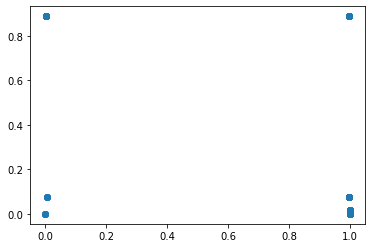

In [33]:
# scatter plot
plt.scatter(df.proba_status_given_request_method, df.rm_proba)
plt.show()

In [34]:
df[(df['proba_status_given_request_method'] > 0.9) & (df['rm_proba'] < 0.2)]

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba,proba_status_given_request_method,rm_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,0,python-requests/2.21.0,0.000040,0.007657,1.000000,107.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3659,0,python-requests/2.21.0,0.003489,0.076213,0.996244,1061.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:05,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-17 06:15:06,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0


In [35]:
ip_df = pd.DataFrame(df.ip.value_counts())
ip_df["proba"] = ip_df.ip / df.shape[0]
ip_df

,ip,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502
24.26.242.9,21,0.001502
52.87.230.102,2,0.000143
35.175.171.137,2,0.000143
70.121.214.34,2,0.000143
95.31.16.121,1,0.000072


In [36]:
status_df = pd.DataFrame(df.status.value_counts())
status_df["proba"] = status_df.status / df.shape[0]
status_df

,status,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


In [37]:
size_df = pd.DataFrame(df['size'].value_counts())
size_df["proba"] = size_df['size'] / df.shape[0]
size_df

,size,proba
494819,705,0.050436
3561,548,0.039204
3659,291,0.020818
1328,229,0.016383
1787,219,0.015667
...,...,...
343913,1,0.000072
126,1,0.000072
360297,1,0.000072
278377,1,0.000072


In [38]:
dest_df = pd.DataFrame(df.destination.value_counts(dropna=False))
dest_df["proba"] = dest_df.destination / df.shape[0]
dest_df

,destination,proba
0,13953,0.998211
https://python.zach.lol/,4,0.000286
https://ds.codeup.com/8.3_Acquire/,3,0.000215
https://python.zach.lol/api/v1/,2,0.000143
https://python.zach.lol/api/v1/stores?page=1,2,0.000143
https://python.zach.lol/api/v1/stores?page=2,1,0.000072
https://python.zach.lol/api/v1//api/v1/items,1,0.000072
https://python.zach.lol/api/v1/stores?page=0,1,0.000072
https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!,1,0.000072
http://localhost:8888/notebooks/acquire.ipynb,1,0.000072


In [39]:
ra_df = pd.DataFrame(df.request_agent.value_counts(dropna=False))
ra_df["proba"] = ra_df.request_agent / df.shape[0]
ra_df

,request_agent,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


In [40]:
rm_df = pd.DataFrame(df.request_method.value_counts())
rm_df["proba"] = rm_df.request_method / df.shape[0]
rm_df

,request_method,proba
GET /api/v1/sales HTTP/1.1,12403,0.887323
GET /api/v1/items HTTP/1.1,1065,0.076191
GET /api/v1/stores HTTP/1.1,229,0.016383
GET / HTTP/1.1,107,0.007655
GET /documentation HTTP/1.1,100,0.007154
GET /favicon.ico HTTP/1.1,26,0.001860
GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
GET /api/v1/items/next_page HTTP/1.1,5,0.000358
GET /api/v1/ HTTP/1.1,4,0.000286
